# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [ ]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark.sql.types import IntegerType,StringType
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Capastone") \
    .getOrCreate()

df = spark.read.json("mini_sparkify_event_data.json")


In [3]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Remove empty user id since they're mostly not registered 
df=df.filter(df.userId != '')


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [5]:
df.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



In [6]:
df.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [7]:
def groupby_col(data, column):
    """
    Return values with row count of a given column in the dataset.
    
    Inputs:
        data (DataFrame): The data set. 
        column (str): The name of a target column.

    Output:
        DataFrame: A dataframe query sorted by count descending.
    """
    return data.groupby(column).count().sort(desc('count'))

In [8]:
# We can see that the Next song page is the most used then the Thumps up then Home
groupby_col(df,'page').show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



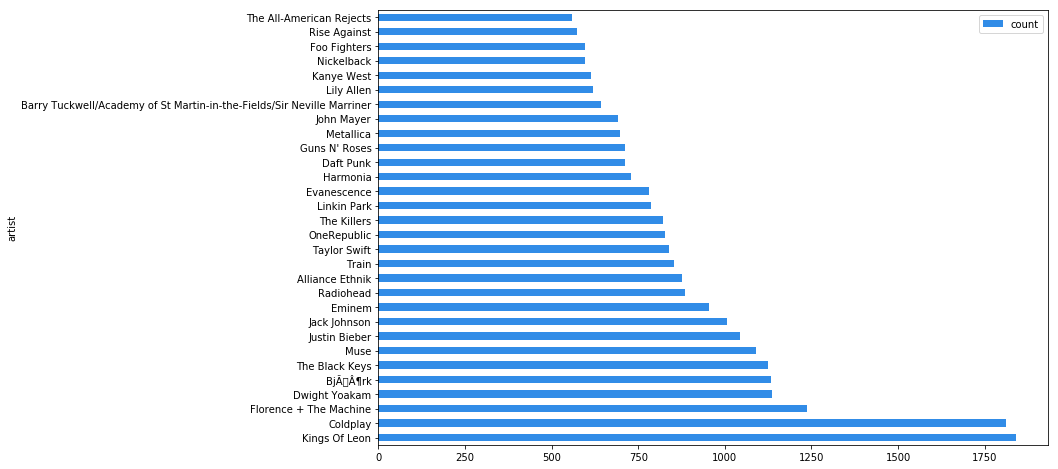

In [25]:
# Here we can see the top artist played
top_artist=groupby_col(df.where(~df.artist.isNull()),'artist').toPandas().head(30)
top_artist.plot(x='artist',y='count',kind='barh',color='#318ce7',figsize=(12,8));


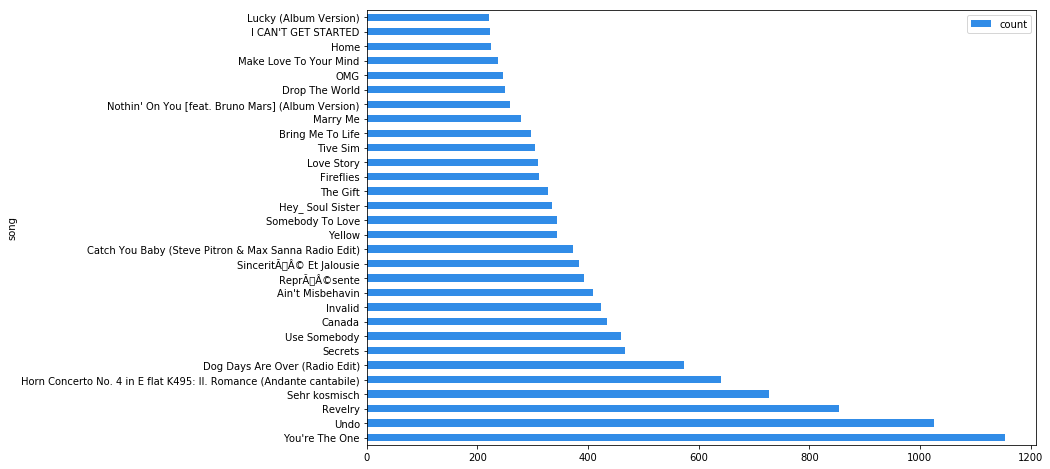

In [26]:
# Here are the top song played
top_songs=groupby_col(df.where(~df.song.isNull()),'song').toPandas().head(30)
top_songs.plot(x='song',y='count',kind='barh',color='#318ce7',figsize=(12,8));

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [36]:
flag_churn = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())
df=df.withColumn('Churn_Flag',flag_churn('page'))


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# The count of people who canceled their subscription vs those who stayed
groupby_col(df,'Churn_Flag').show()

+----------+------+
|Churn_Flag| count|
+----------+------+
|         0|278102|
|         1|    52|
+----------+------+



In [13]:
userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_cancel = df.withColumn('Churn',max('Churn_Flag').over(userwindow))

In [14]:
df_cancel.dropDuplicates(['userId']).select('Churn').groupby('Churn').count().collect()


[Row(Churn=1, count=52), Row(Churn=0, count=173)]

We have 52 Chruned user over 173 that are not churned that's almost 23.1% churned users, this is unbalanced data but we will do some analysis on it

In [44]:
# The most visited pages by the users who canceled their subscriptions
page_canceled=groupby_col(df_cancel.where(df_cancel.Churn==1),['page']).toPandas()
page_active=groupby_col(df_cancel.where(df_cancel.Churn==0),['page']).toPandas()
merged=pd.merge(page_active,page_canceled,how='outer',on=['page'],suffixes=('_active','_canceled'))
merged.count_active.fillna(0,inplace=True)
merged

,page,count_active,count_canceled
0,NextSong,191714.0,36394
1,Thumbs Up,10692.0,1859
2,Home,8410.0,1672
3,Add to Playlist,5488.0,1038
4,Add Friend,3641.0,636
5,Roll Advert,2966.0,967
6,Logout,2673.0,553
7,Thumbs Down,2050.0,496
8,Downgrade,1718.0,337
9,Settings,1244.0,270


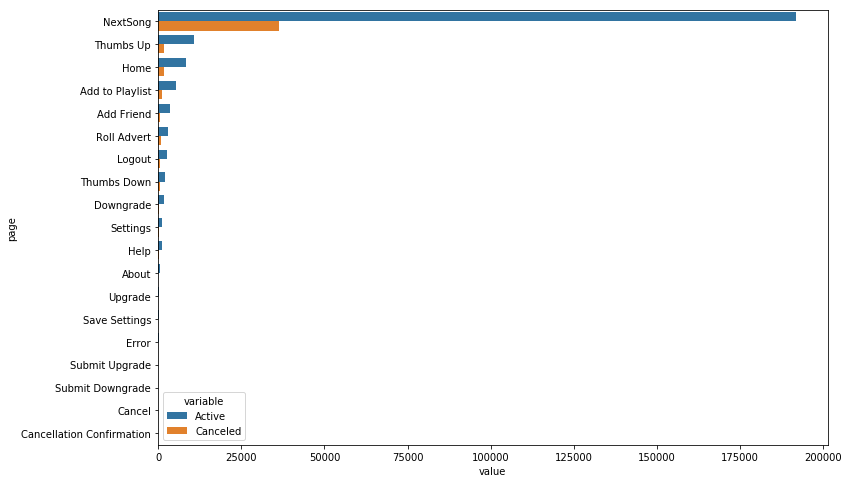

In [47]:
# I melted the dataframe because I want to flag the pages with their counts so I can plot it 
page=pd.melt(merged, id_vars=['page'], value_vars=['count_active','count_canceled'])
page.replace(to_replace='count_active',value='Active',inplace=True)
page.replace(to_replace='count_canceled',value='Canceled',inplace=True)
page=page.sort_values('value',ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(y='page',x='value',hue='variable',data=page)

Here we can see the behivor of the users who canceled their subscriptions vs the users who stayed even though the dataset is unbalnced we can see the users who churned aren't active as the should be 

In [51]:
gender=df_cancel.dropDuplicates(['userId']).select('Churn','gender').groupby('Churn','gender').count().toPandas()
# gender=merged.groupby('gender',as_index=False).agg({'count_active':'sum','count_canceled':'sum'})
# I melted the dataframe because I want to flag the gender with their counts so I can plot it 
gender

,Churn,gender,count
0,1,F,20
1,0,M,89
2,1,M,32
3,0,F,84


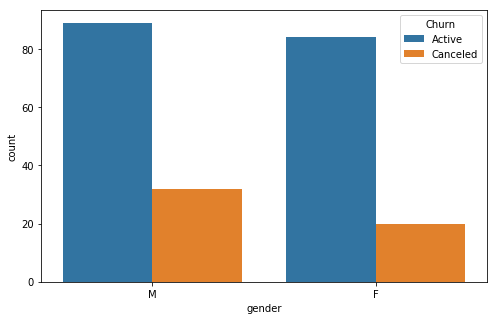

In [56]:
gender=df_cancel.dropDuplicates(['userId']).select('Churn','gender').groupby('Churn','gender').count().toPandas()
gender['Churn']=gender['Churn'].astype(str)
gender.replace(to_replace='0',value='Active',inplace=True)
gender.replace(to_replace='1',value='Canceled',inplace=True)
gender=gender.sort_values('count',ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x='gender',y='count',hue='Churn',data=gender)

We can see that the Male users are canceling their subscription more than the Females even though there aren't any big difference in the population.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [18]:
df.createOrReplaceTempView('df_'); # Create a df Table to be used for SQL queries

In [19]:
features = spark.sql("SELECT CAST(userId as INT) , \
    max(Churn_Flag) as label, \
    count(case when page = 'NextSong' then userId else null end)        as song_count, \
    count(case when page = 'Error' then userId else null end)           as error, \
    count(case when page = 'Add Friend' then userId else null end)      as friends, \
    count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
    count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
    count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
    count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
    round(avg(distinct sessionId))                                      as count_session_dist, \
    round((max(ts) - min(registration))/86400)                          as duration \
    FROM df_ \
    GROUP BY userId")
features=features.na.drop()

In [20]:
features.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- song_count: long (nullable = false)
 |-- error: long (nullable = false)
 |-- friends: long (nullable = false)
 |-- playlist_count: long (nullable = false)
 |-- thumbs_up: long (nullable = false)
 |-- thumbs_down: long (nullable = false)
 |-- downgrade: long (nullable = false)
 |-- count_session_dist: double (nullable = true)
 |-- duration: double (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [21]:
train,test=features.randomSplit([0.8,0.2])

# Assembler to fit every feature in 1 Column 
assembler = VectorAssembler(inputCols=["userId",'song_count','error','friends'\
                                       ,'playlist_count','thumbs_up','thumbs_down'\
                                       ,'downgrade','count_session_dist','duration'], outputCol="InputFeatures")
scaler = Normalizer(inputCol="InputFeatures", outputCol="features")

lr = LogisticRegression()
rf = RandomForestClassifier()
gbt = GBTClassifier()

lr_pipeline=Pipeline(stages=[assembler,scaler,lr])
rf_pipeline=Pipeline(stages=[assembler,scaler,rf])
gbt_pipeline=Pipeline(stages=[assembler,scaler,gbt])

#### Logistic Regression

In [22]:
lr_model=lr_pipeline.fit(train)
lr_pred=lr_model.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy: {}'.format(evaluator.evaluate(lr_pred, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(lr_pred, {evaluator.metricName: "f1"})))

Accuracy: 0.7692307692307693
F-1 Score:0.7078593048742302


#### Random Forest Classifier

In [23]:
rf_model=rf_pipeline.fit(train)
rf_pred=rf_model.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy: {}'.format(evaluator.evaluate(rf_pred, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(rf_pred, {evaluator.metricName: "f1"})))

Accuracy: 0.7435897435897436
F-1 Score:0.7149725274725275


#### GBT Classifier

In [24]:
gbt_model=gbt_pipeline.fit(train)
gbt_pred=gbt_model.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy: {}'.format(evaluator.evaluate(gbt_pred, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})))

Accuracy: 0.6410256410256411
F-1 Score:0.6410256410256411


### Based on the accracy and the  F-1 score I'm choosing the Random Forest Classifier to hypertune the model parameter

In [31]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .build()
#     .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])

evaluator=MulticlassClassificationEvaluator(metricName="f1")


crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)
cv_lr = crossval.fit(train)

In [32]:
print(cv_lr.getEstimatorParamMaps()[ np.argmax(cv_lr.avgMetrics) ])

{Param(parent='LogisticRegression_f115d370c840', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_f115d370c840', name='fitIntercept', doc='whether to fit an intercept term.'): False}


In [33]:
lr_best = LogisticRegression(regParam=0.01,fitIntercept=False)
lr_best_pipeline=Pipeline(stages=[assembler,scaler,lr_best])
lr_best_model = lr_best_pipeline.fit(train)
results_final = lr_best_model.transform(test)

In [34]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))

Accuracy: 0.7692307692307693
F-1 Score:0.7337278106508877


## Conclusion

### Summary 
In this notebook we implemented a model trying to predict customer churn. We removed rows with no userId, chceked the pages that are frequently visited, what are the best song and the top artist then we build 3 models to predict churn rate for users then we picked 1 of them and we hyperpramter tuned the model. 
Even though the dataset is small I belive this model will do good things given a bigger dataset.

### Reflection
This project helped me indulge more into Spark enviroment to analyze big data, by analyzing chrn rate for each user business can save a lot of money not losing any users.

One of the difficult things was to learn pyspark for the first time and finishing this project in the same time.

### Improvement
I think there are a lot of improvment can be made to the features we used but I'm happy of what I come up with, with the help of domain expertise I think we can come up with better features and testing on larger dataset.